In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.stats import zscore
import warnings
warnings.filterwarnings('ignore')


In [2]:
customers = pd.read_csv('Customers.csv', parse_dates=['SignupDate'])
transactions = pd.read_csv('Transactions.csv', parse_dates=['TransactionDate'])

In [3]:
max_date = transactions['TransactionDate'].max()
rfm = transactions.groupby('CustomerID').agg(
    Frequency=('TransactionID', 'count'),
    Monetary=('TotalValue', 'sum'),
    LastPurchaseDate=('TransactionDate', 'max')
).reset_index()
rfm['Recency'] = (max_date - rfm['LastPurchaseDate']).dt.days

In [4]:
merged = pd.merge(customers, rfm, on='CustomerID')
merged['Tenure'] = (max_date - merged['SignupDate']).dt.days

In [5]:
merged = pd.get_dummies(merged, columns=['Region'])

In [6]:
features = merged[['Tenure', 'Recency', 'Frequency', 'Monetary', 
                   'Region_Asia', 'Region_Europe', 'Region_North America', 
                   'Region_South America']]

In [7]:
features = features.apply(pd.to_numeric, errors='coerce')
features = features.astype({col: 'int' for col in features.select_dtypes(include='bool').columns})

In [8]:
z_scores = np.abs(zscore(features))
filtered_features = features[(z_scores < 3).all(axis=1)]

In [9]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(filtered_features)

In [10]:
def evaluate_clustering(labels, features):
    if len(set(labels)) > 1:  
        db_index = davies_bouldin_score(features, labels)
        silhouette = silhouette_score(features, labels)
        return db_index, silhouette
    else:
        return None, None  

In [11]:
range_n_clusters = range(2, 11)
silhouette_scores = []

In [12]:
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_features)
    silhouette_avg = silhouette_score(scaled_features, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"n_clusters = {n_clusters}, Silhouette Score = {silhouette_avg:.2f}")

n_clusters = 2, Silhouette Score = 0.20
n_clusters = 3, Silhouette Score = 0.29
n_clusters = 4, Silhouette Score = 0.38
n_clusters = 5, Silhouette Score = 0.32
n_clusters = 6, Silhouette Score = 0.34
n_clusters = 7, Silhouette Score = 0.32
n_clusters = 8, Silhouette Score = 0.30
n_clusters = 9, Silhouette Score = 0.30
n_clusters = 10, Silhouette Score = 0.30


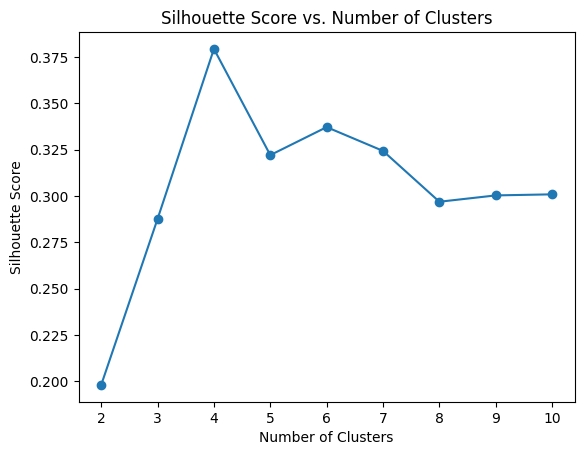

In [13]:
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.show()

In [14]:
distortions = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    distortions.append(kmeans.inertia_)

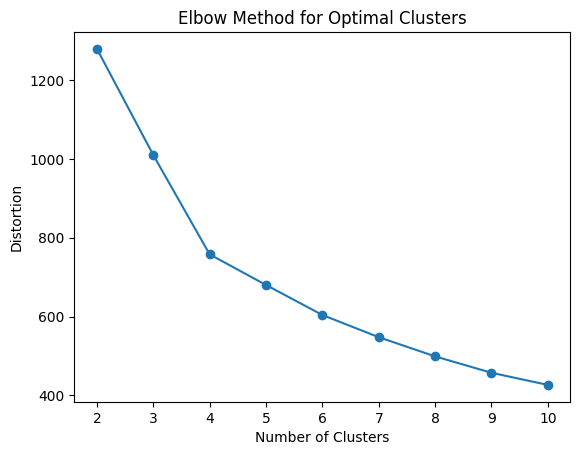

In [15]:
plt.plot(range(2, 11), distortions, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.title('Elbow Method for Optimal Clusters')
plt.show()

In [16]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_features)

In [17]:
db_index, silhouette = evaluate_clustering(kmeans_labels, scaled_features)
print(f"K-Means: DB Index = {db_index:.2f}, Silhouette Score = {silhouette:.2f}")

K-Means: DB Index = 1.15, Silhouette Score = 0.38


In [18]:
agglo = AgglomerativeClustering(n_clusters=4)
agglo_labels = agglo.fit_predict(scaled_features)
db_index, silhouette = evaluate_clustering(agglo_labels, scaled_features)
print(f"Agglomerative: DB Index = {db_index:.2f}, Silhouette Score = {silhouette:.2f}")

Agglomerative: DB Index = 1.24, Silhouette Score = 0.37


In [19]:
best_db_index = float('inf')
best_params = None

In [20]:
for eps in [0.3, 0.5, 0.7, 1.0]:
    for min_samples in [3, 5, 10]:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(scaled_features)
        db_index, silhouette = evaluate_clustering(dbscan_labels, scaled_features)
        if db_index and db_index < best_db_index:
            best_db_index = db_index
            best_params = (eps, min_samples)
        print(f"DBSCAN (eps={eps}, min_samples={min_samples}): DB Index = {db_index}, Silhouette Score = {silhouette}")

print(f"Best DBSCAN Params: eps={best_params[0]}, min_samples={best_params[1]}")

DBSCAN (eps=0.3, min_samples=3): DB Index = 1.2910869665290143, Silhouette Score = -0.09331372222017721
DBSCAN (eps=0.3, min_samples=5): DB Index = None, Silhouette Score = None
DBSCAN (eps=0.3, min_samples=10): DB Index = None, Silhouette Score = None
DBSCAN (eps=0.5, min_samples=3): DB Index = 1.253649345341979, Silhouette Score = -0.2632351030000489
DBSCAN (eps=0.5, min_samples=5): DB Index = None, Silhouette Score = None
DBSCAN (eps=0.5, min_samples=10): DB Index = None, Silhouette Score = None
DBSCAN (eps=0.7, min_samples=3): DB Index = 1.3646332069595013, Silhouette Score = -0.2188243268475616
DBSCAN (eps=0.7, min_samples=5): DB Index = 1.1849331761932813, Silhouette Score = 0.005034450060857286
DBSCAN (eps=0.7, min_samples=10): DB Index = None, Silhouette Score = None
DBSCAN (eps=1.0, min_samples=3): DB Index = 1.6359442459461488, Silhouette Score = 0.06621987934663232
DBSCAN (eps=1.0, min_samples=5): DB Index = 1.7309557057329046, Silhouette Score = -0.01081474255718243
DBSCAN 

In [21]:
tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(scaled_features)


Text(0.5, 1.0, 'K-Means Clusters (t-SNE)')

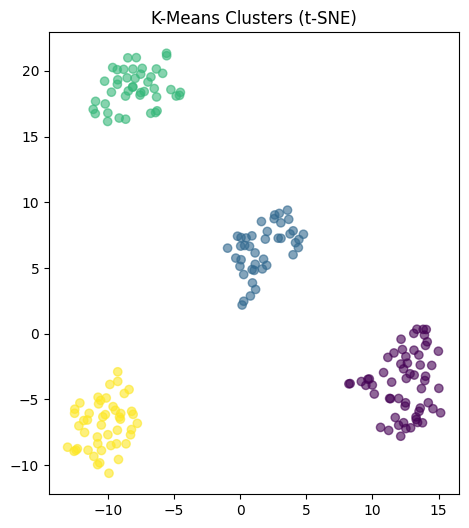

In [22]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.6)
plt.title('K-Means Clusters (t-SNE)')


Text(0.5, 1.0, 'Agglomerative Clusters (t-SNE)')

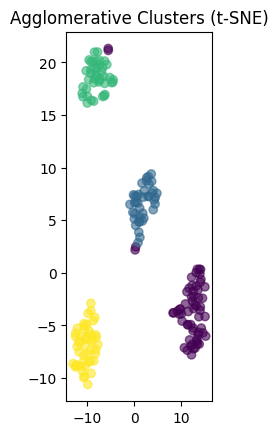

In [23]:
plt.subplot(1, 3, 2)
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=agglo_labels, cmap='viridis', alpha=0.6)
plt.title('Agglomerative Clusters (t-SNE)')

Text(0.5, 1.0, 'DBSCAN Clusters (t-SNE)')

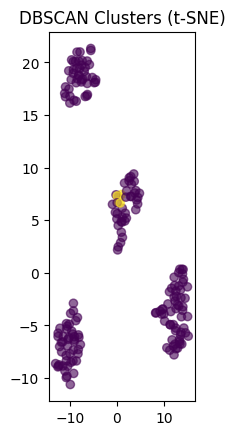

In [24]:
plt.subplot(1, 3, 3)
dbscan_labels = DBSCAN(eps=best_params[0], min_samples=best_params[1]).fit_predict(scaled_features)
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=dbscan_labels, cmap='viridis', alpha=0.6)
plt.title('DBSCAN Clusters (t-SNE)')

In [25]:
plt.show()

In [26]:
filtered_merged = merged.loc[filtered_features.index]
filtered_merged['Cluster'] = kmeans_labels
cluster_summary = filtered_merged.groupby('Cluster').agg(
    Avg_Recency=('Recency', 'mean'),
    Avg_Frequency=('Frequency', 'mean'),
    Avg_Monetary=('Monetary', 'mean'),
    Avg_Tenure=('Tenure', 'mean')
)
print(cluster_summary)

         Avg_Recency  Avg_Frequency  Avg_Monetary  Avg_Tenure
Cluster                                                      
0          63.050847       5.152542   3717.840000  598.406780
1          63.642857       5.142857   3574.407857  536.761905
2          73.477273       5.500000   3431.696591  429.250000
3          70.750000       4.645833   3234.627083  552.937500
